In [4]:
import numpy as np  
import pandas as pd  
from sklearn import datasets  
from sklearn.model_selection import train_test_split  
from sklearn.cluster import KMeans  
import matplotlib.pyplot as plt  
import seaborn as sns  

# بارگذاری داده‌های دیابت  
diabetes = datasets.load_diabetes()  
X = diabetes.data  
Y = diabetes.target  

# تبدیل به DataFrame  
df = pd.DataFrame(X, columns=diabetes.feature_names)  
df['target'] = Y  
# حذف سطرهای حاوی مقادیر گم‌شده  
df = df.dropna()  

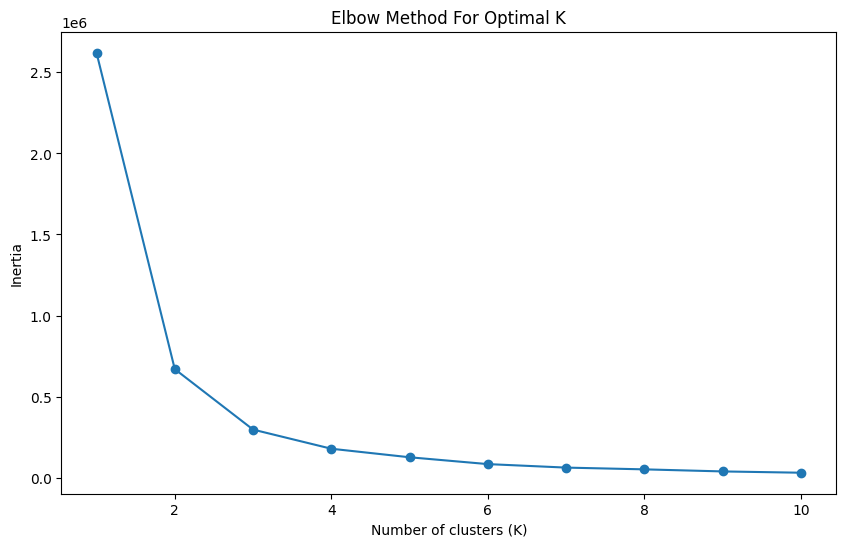

In [5]:
# پیدا کردن K مناسب با روش Elbow  
inertia = []  
K = range(1, 11)  
for k in K:  
    kmeans = KMeans(n_clusters=k, random_state=0)  
    kmeans.fit(df['target'].values.reshape(-1, 1))  # تبدیل تارگت به آرایه دو بعدی  
    inertia.append(kmeans.inertia_)  

# پلات کردن  
plt.figure(figsize=(10, 6))  
plt.plot(K, inertia, marker='o')  
plt.xlabel('Number of clusters (K)')  
plt.ylabel('Inertia')  
plt.title('Elbow Method For Optimal K')  
plt.show()  

# تعیین K بهینه  
K_optimal = 3  
kmeans = KMeans(n_clusters=K_optimal, random_state=0)  
df['target_class'] = kmeans.fit_predict(df['target'].values.reshape(-1, 1))  

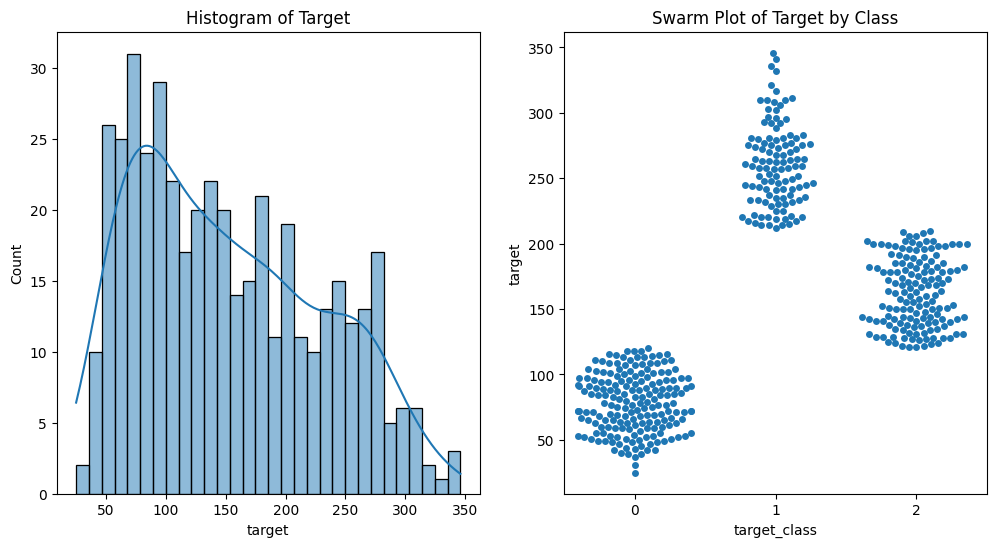

In [6]:
plt.figure(figsize=(12, 6))  

# پلات هیستوگرام  
plt.subplot(1, 2, 1)  
sns.histplot(df['target'], bins=30, kde=True)  
plt.title('Histogram of Target')  

# پلات Swarm  
plt.subplot(1, 2, 2)  
sns.swarmplot(x=df['target_class'], y=df['target'])  
plt.title('Swarm Plot of Target by Class')  

plt.show()  

In [7]:
# تقسیم داده‌ها به مجموعه‌های آموزش و تست  
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['target', 'target_class']),   
                                                    df['target'],   
                                                    test_size=0.2,   
                                                    random_state=0)  

In [8]:
from sklearn.neighbors import KNeighborsRegressor  
from sklearn.metrics import mean_squared_error, r2_score  

# k برابر با r^2(X_train) را محاسبه می‌کنیم  
k = int(np.sqrt(len(X_train)))  

# ایجاد مدل KNN Regressor  
knn = KNeighborsRegressor(n_neighbors=k)  

# آموزش مدل با داده‌های آموزشی  
knn.fit(X_train, y_train)  

# پیش‌بینی مقادیر مورد تست  
y_pred = knn.predict(X_test)  

# محاسبه r^2 و MSE  
r_squared = r2_score(y_test, y_pred)  
mse = mean_squared_error(y_test, y_pred)  

print(f'R^2: {r_squared}, MSE: {mse}')  

R^2: 0.3319991259278554, MSE: 3425.459737827716


In [14]:

# پیش‌بینی با روش K نزدیک‌ترین همسایگان  
predicted_values_new_method = []  

for case in X_test.values:  
    case_j = []  
    for j in range(X_train.shape[1]):  
        # calculate distances از K همسایگان نزدیک  
        distances = np.linalg.norm(X_train.values - case, axis=1)  
        k_nearest_indices = distances.argsort()[:k]  

        # f_j: تمام X_train هایی که ویژگی آنها فقط f_j است  
        f_j_neighbors = X_train.iloc[k_nearest_indices, j]  
        case_j.extend(f_j_neighbors)  

    # ذخیره‌سازی p_j  
    p_j = []  
    for j_val in set(case_j):  # برای هر مقدار یکتا در case_j  
        indices = np.where(X_train.iloc[:, j] == j_val)[0]  

        if len(indices) > 0:  # اگر همسایگان وجود داشته باشند  
            p_target = y_train.iloc[indices]  
            p_j.append(p_target.mean())  # محاسبه میانگین تارگت برای آن دسته از نمونه‌ها  

    if p_j:  # فقط اگر p_j دارای مقادیر معتبر باشد  
        predicted_values_new_method.append(np.mean(p_j))  
    else:  
        predicted_values_new_method.append(0)  # یا مقدار پیش‌فرض دیگر مثل 0  

predicted_values_new_method = np.array(predicted_values_new_method) 
print(predicted_values_new_method )

[191.96358543 137.51388889 131.83888889 137.36666667 144.20791246
 191.93981481 149.29665072 137.94136321 118.13888889 159.41666667
 113.97222222 157.50925926 135.48304473 133.96717172 184.54030501
  98.05555556 143.33333333 125.33333333 150.75841751 225.16666667
 151.08479756 128.81565657 137.4547619  129.06481481 114.91353383
 135.69444444 118.75555556 140.13840156 185.11805556 162.48809524
 164.24136321 140.86666667 152.39444444 148.7814992  139.58068783
 138.02314815 153.21331738 160.42165072 149.68880758 162.47222222
 135.03333333 136.10277778 172.98148148 165.40013228 157.67080897
 113.08888889 130.56993464 141.10932858 156.70883838 205.76388889
 137.86565657 116.66666667 173.18013468 161.09210526 159.41666667
 140.35151515 127.6754902  116.83333333 140.07592593 146.28660131
 143.71336898 124.85930736 149.86389176 162.86161616 204.84722222
 149.17365607 127.30050505 252.11111111 148.62565505 138.70909091
 128.94686717 137.29210526 142.85139319 102.31666667 144.5765003
 144.032004

In [15]:
# مقایسه پیش‌بینی‌های جدید با مقادیر واقعی  
new_r_squared = r2_score(y_test, predicted_values_new_method)  
new_mse = mean_squared_error(y_test, predicted_values_new_method)  

print(f'New R^2: {new_r_squared}, New MSE: {new_mse}')  

New R^2: 0.20270231177821962, New MSE: 4088.4843659229423
